In [ ]:
from pathlib import Path
import pandas as pd

base_dir = Path("./outputs")
models = ["SwinUNetR_Mlp_LeakyReLU", "SwinUNetR_SwiGLU_LeakyReLU", "SwinUNetR_Mlp_ReLUSquared", "SwinUNetR_SwiGLU_ReLUSquared"]
model_configs = ["base_model", "feature_size_12", "model_depths_1_1_1_1"]
all_val_data = []
all_train_data = []
for model_config in model_configs:
    noko_dir = base_dir / model_config / "noko_runs"
    paths = list(noko_dir.iterdir())
    paths.sort()
    for i, model in enumerate(models):
        train_data_path = paths[i] / "Training" / "Epoch loss.csv"
        train_data = pd.read_csv(train_data_path)
        train_data["model"] = model
        train_data["model_config"] = model_config
        val_data_path = paths[i] / "Validation" / "Mean Loss (epoch).csv"
        val_data = pd.read_csv(val_data_path)
        val_data["model"] = model
        val_data["model_config"] = model_config
        all_val_data.append(val_data)
        all_train_data.append(train_data)
        
feature_size_map = {
    "base_model": 24,
    "feature_size_12": 12,
    "model_depths_1_1_1_1": 24
}

depths_map = {
    "base_model": 2,
    "feature_size_12": 2,
    "model_depths_1_1_1_1": 1
}

all_train_data = pd.concat(all_train_data)
all_train_data["model"].str.split("_", expand=True)
all_train_data["mlp"] = all_train_data["model"].str.split("_", expand=True)[1]
all_train_data["activation"] = all_train_data["model"].str.split("_", expand=True)[2]
all_train_data.rename(columns={"$step": "epoch"}, inplace=True)
all_train_data["feature_size"] = all_train_data["model_config"].map(feature_size_map)
all_train_data["depths"] = all_train_data["model_config"].map(depths_map)

all_val_data = pd.concat(all_val_data)
all_val_data["model"].str.split("_", expand=True)
all_val_data["mlp"] = all_val_data["model"].str.split("_", expand=True)[1]
all_val_data["activation"] = all_val_data["model"].str.split("_", expand=True)[2]
all_val_data.rename(columns={"$step": "epoch"}, inplace=True)
all_val_data["feature_size"] = all_val_data["model_config"].map(feature_size_map)
all_val_data["depths"] = all_val_data["model_config"].map(depths_map)


all_train_data.head()
all_val_data.head()

val_loss_long = all_val_data.copy()
train_loss_long = all_train_data.copy()

FileNotFoundError: [Errno 2] No such file or directory: '/clusterfs/nvme/segment_3d/tests/supervised_models/train_swin_unetr_cellseg3d_mesoSPIM/base_model/noko_runs'

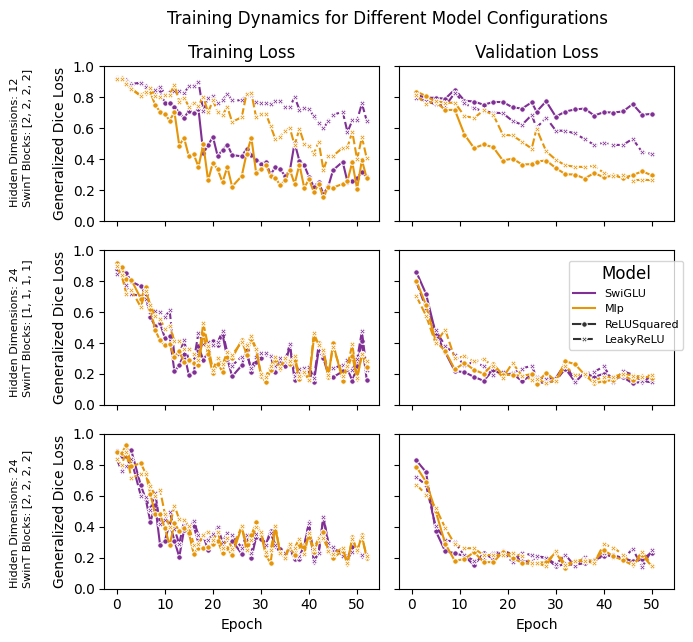

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Make a tall grid plot with each row for a (feature_size, depths) group,
# columns: Training Loss (left), Validation Loss (right).
# Now with shared x and y axes, and fixed y axis from 0 to 1

# Find all groups
groups = list(val_loss_long.groupby(["feature_size", "depths"], as_index=True).groups.keys())
n_groups = len(groups)

# Set up a grid of subplots with shared x and y axes, transposed
fig, axes = plt.subplots(nrows=n_groups, ncols=2, figsize=(7, 7), sharex='all', sharey='all')
if n_groups == 1:
    # Ensure axes is always a 2D array for consistency (in case only one group)
    axes = axes.reshape((1, 2))

collected_legend = None

# Column labels ("Training" and "Validation")
axes[0, 0].set_title("Training Loss", fontsize=12)
axes[0, 1].set_title("Validation Loss", fontsize=12)

for i, group in enumerate(groups):
    # Validation loss data (right column)
    val_data = val_loss_long[(val_loss_long["feature_size"] == group[0]) & (val_loss_long["depths"] == group[1])]
    # Training loss data (left column)
    train_data = train_loss_long[(train_loss_long["feature_size"] == group[0]) & (train_loss_long["depths"] == group[1])]

    # Training Loss Plot (left column)
    ax1 = axes[i, 0]
    lines_train = sns.lineplot(
        data=train_data,
        x="epoch",
        y="loss",
        hue="mlp",
        style="activation",
        markers=True,
        markersize=4,
        palette="CMRmap",
        ax=ax1
    )
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Generalized Dice Loss")
    ax1.set_ylim(0, 1)  # Fix y-axis from 0 to 1
    if i != 0:
        ax1.set_title("")  # Remove old title

    # Row label (to the left of the row), using fig.text at vertical center of subplot
    row_label = f"Hidden Dimensions: {group[0]}\nSwinT Blocks: {group[1]}"
    ax_pos = ax1.get_position()
    fig.text(
        0.03, ax_pos.y0 + 0.5*(ax_pos.y1 - ax_pos.y0), row_label,
        va='center', ha='left', rotation=90, fontsize=8
    )

    # Collect the legend from the first plot
    if i == 0 and ax1.get_legend():
        handles, labels = ax1.get_legend_handles_labels()
        # Filter legend for unique & non-empty labels except for the automatic hue/style headers
        filtered = [(h, l) for h, l in zip(handles, labels) if l not in ["mlp", "activation"] and l.strip() != ""]
        if filtered:
            line_handles, line_labels = zip(*filtered)
            collected_legend = (line_handles, line_labels)
    if ax1.get_legend():
        ax1.get_legend().remove()

    # Validation Loss Plot (right column)
    ax2 = axes[i, 1]
    lines_val = sns.lineplot(
        data=val_data,
        x="epoch",
        y="loss",
        hue="mlp",
        style="activation",
        markers=True,
        markersize=4,
        palette="CMRmap",
        ax=ax2
    )
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Generalized Dice Loss")
    ax2.set_ylim(0, 1)  # Fix y-axis from 0 to 1
    if i != 0:
        ax2.set_title("")
    if ax2.get_legend():
        ax2.get_legend().remove()

# Add the combined legend to the right of the figure (only one legend for all subplots)
if collected_legend:
    # Place legend in upper right outside plot area
    fig.legend(
        collected_legend[0], collected_legend[1],
        title="Model",
        loc='upper right',
        bbox_to_anchor=(1, 0.6),
        ncol=1,
        fontsize=8,
        title_fontsize=12,
        borderaxespad=0.5,
        frameon=True
    )

plt.suptitle("Training Dynamics for Different Model Configurations", fontsize=12, y=0.95, x=0.57)

plt.tight_layout(rect=(0.07, 0.04, 1, 0.97))
plt.savefig("/clusterfs/nvme/martinalvarez/GitHub/segmentation_case_study/notebooks/loss_plot_tall.png", dpi=400, bbox_inches='tight')

plt.show()


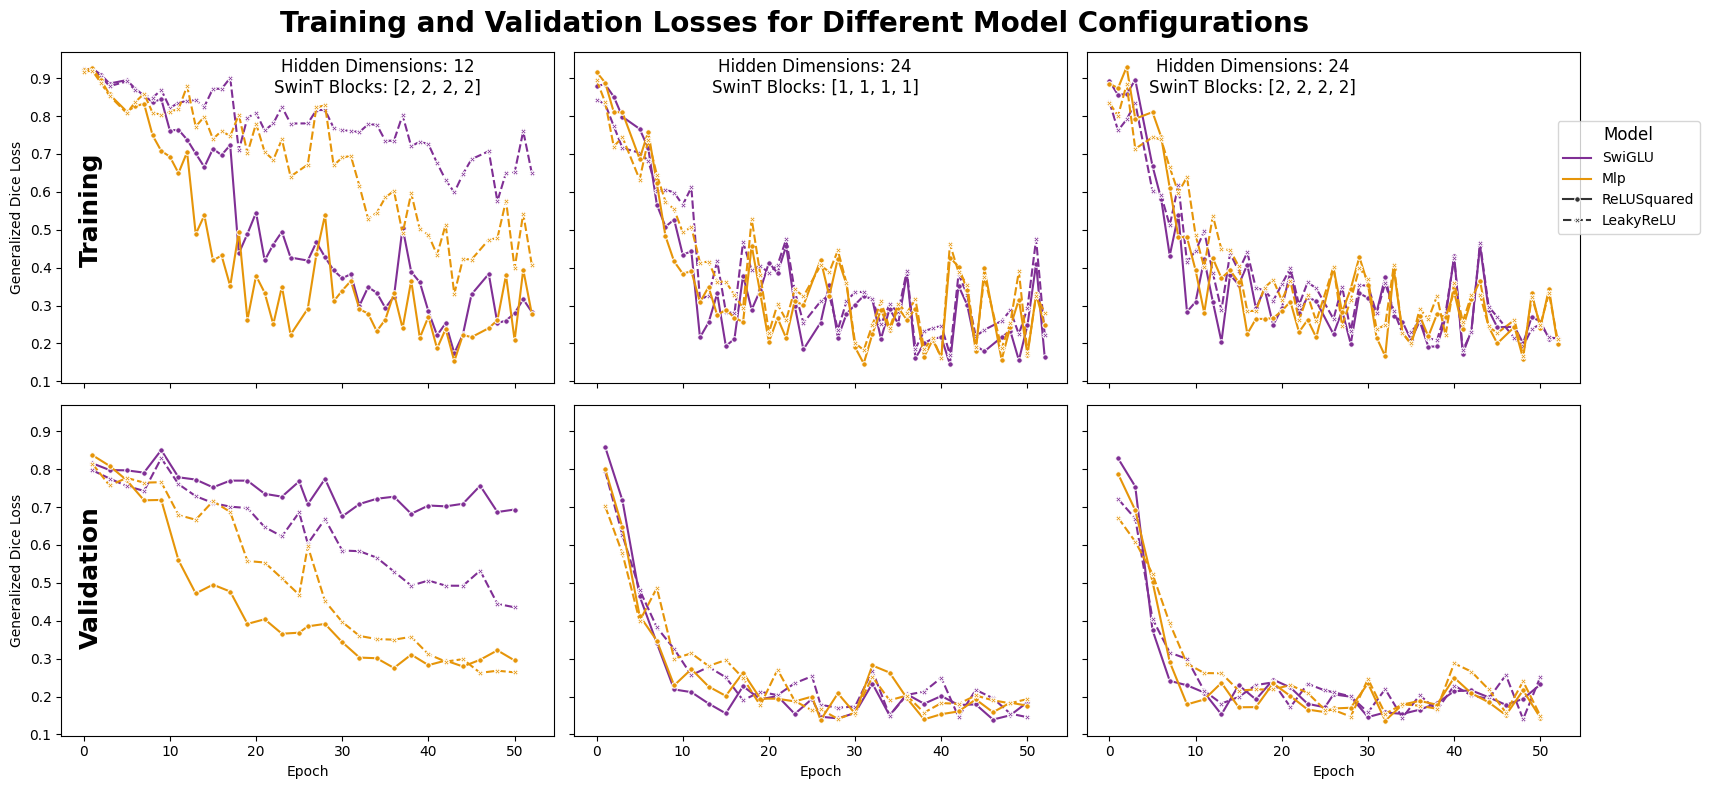

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Make a wide grid plot with each column for a (feature_size, depths) group,
# rows: Training Loss (top), Validation Loss (bottom).
# Now with shared x and y axes

# Find all groups
groups = list(val_loss_long.groupby(["feature_size", "depths"], as_index=True).groups.keys())
n_groups = len(groups)

# Set up a grid of subplots with shared x and y axes
fig, axes = plt.subplots(nrows=2, ncols=n_groups, figsize=(16, 8), sharex='all', sharey='all')
if n_groups == 1:
    # Ensure axes is always a 2D array for consistency (in case only one group)
    axes = axes.reshape((2, 1))

collected_legend = None

# Row labels ("Training" and "Validation")
fig.text(0.06, 0.73, "Training", ha="center", va="center", fontsize=18, weight='bold', rotation=90)
fig.text(0.06, 0.27, "Validation", ha="center", va="center", fontsize=18, weight='bold', rotation=90)

for j, group in enumerate(groups):
    # Validation loss data (bottom row)
    val_data = val_loss_long[(val_loss_long["feature_size"] == group[0]) & (val_loss_long["depths"] == group[1])]
    # Training loss data (top row)
    train_data = train_loss_long[(train_loss_long["feature_size"] == group[0]) & (train_loss_long["depths"] == group[1])]

    # Training Loss Plot (top row)
    ax1 = axes[0, j]
    lines_train = sns.lineplot(
        data=train_data,
        x="epoch",
        y="loss",
        hue="mlp",
        style="activation",
        markers=True,
        markersize=4,
        palette="CMRmap",
        ax=ax1
    )
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Generalized Dice Loss")
    ax1.set_title("")  # Remove old title

    # Collect the legend from the first plot
    if j == 0 and ax1.get_legend():
        handles, labels = ax1.get_legend_handles_labels()
        # Filter legend for unique & non-empty labels except for the automatic hue/style headers
        filtered = [(h, l) for h, l in zip(handles, labels) if l not in ["mlp", "activation"] and l.strip() != ""]
        if filtered:
            line_handles, line_labels = zip(*filtered)
            collected_legend = (line_handles, line_labels)
    if ax1.get_legend():
        ax1.get_legend().remove()

    # Column label (above each column)
    col_label = f"Hidden Dimensions: {group[0]}\nSwinT Blocks: {group[1]}"
    # Place the label above the column using fig.text
    ax_pos = ax1.get_position()
    fig.text(ax_pos.x0 + 0.5 * (ax_pos.x1 - ax_pos.x0), 0.92, col_label, va='top', ha='center', rotation=0, fontsize=12)

    # Validation Loss Plot (bottom row)
    ax2 = axes[1, j]
    lines_val = sns.lineplot(
        data=val_data,
        x="epoch",
        y="loss",
        hue="mlp",
        style="activation",
        markers=True,
        markersize=4,
        palette="CMRmap",
        ax=ax2
    )
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Generalized Dice Loss")
    ax2.set_title("")
    if ax2.get_legend():
        ax2.get_legend().remove()

# Add the combined legend to the right of the figure (only one legend for all subplots)
if collected_legend:
    fig.legend(
        collected_legend[0], collected_legend[1],
        title="Model", 
        loc='upper right', 
        bbox_to_anchor=(1.07, 0.85),
        ncol=1,
        fontsize='medium',
        title_fontsize='large',
        borderaxespad=0.5,
        frameon=True
    )

plt.suptitle("Training and Validation Losses for Different Model Configurations", fontsize=20, weight='bold')

plt.tight_layout()
plt.savefig("/clusterfs/nvme/martinalvarez/GitHub/segmentation_case_study/notebooks/loss_plot_wide.png", dpi=400, bbox_inches='tight')

plt.show()



In [ ]:
ave_val_loss = val_loss_long[val_loss_long["epoch"] > 40].groupby(["feature_size", "depths","mlp", "activation"])["loss"].describe()[["mean", "std"]].round(3)
ave_val_loss.columns = ["Average Validation Loss", "Std. Dev of Validation Loss"]
ave_val_loss.reset_index().to_csv("/clusterfs/nvme/martinalvarez/GitHub/segmentation_case_study/notebooks/ave_val_loss.csv")
ave_val_loss

Average Validation Loss  \
feature_size depths       mlp    activation                             
12           [2, 2, 2, 2] Mlp    LeakyReLU                      0.277   
                                 ReLUSquared                    0.298   
                          SwiGLU LeakyReLU                      0.479   
                                 ReLUSquared                    0.709   
24           [1, 1, 1, 1] Mlp    LeakyReLU                      0.190   
                                 ReLUSquared                    0.174   
                          SwiGLU LeakyReLU                      0.172   
                                 ReLUSquared                    0.166   
             [2, 2, 2, 2] Mlp    LeakyReLU                      0.206   
                                 ReLUSquared                    0.181   
                          SwiGLU LeakyReLU                      0.209   
                                 ReLUSquared                    0.204   

                                              Std. Dev of Validation Loss  
feature_size depths       mlp    activation                                
12           [2, 2, 2, 2] Mlp    LeakyReLU                          0.017  
                                 ReLUSquared                        0.015  
                          SwiGLU LeakyReLU                          0.040  
                                 ReLUSquared                        0.027  
24           [1, 1, 1, 1] Mlp    LeakyReLU                          0.009  
                                 ReLUSquared                        0.015  
                          SwiGLU LeakyReLU                          0.033  
                                 ReLUSquared                        0.020  
             [2, 2, 2, 2] Mlp    LeakyReLU                          0.051  
                                 ReLUSquared                        0.033  
                          SwiGLU LeakyReLU                          0.048  
                                 ReLUSquared                        0.021

In [ ]:
# Get the best epoch for each model
best_epochs = val_loss_long.set_index("epoch").groupby(["feature_size", "depths", "mlp", "activation"])["loss"].idxmin()
best_epochs.name = "Best Epoch"
best_epochs.reset_index().to_csv("/clusterfs/nvme/martinalvarez/GitHub/segmentation_case_study/notebooks/best_epochs.csv")
best_epochs

feature_size  depths        mlp     activation 
12            [2, 2, 2, 2]  Mlp     LeakyReLU      46
                                    ReLUSquared    36
                            SwiGLU  LeakyReLU      50
                                    ReLUSquared    30
24            [1, 1, 1, 1]  Mlp     LeakyReLU      28
                                    ReLUSquared    26
                            SwiGLU  LeakyReLU      50
                                    ReLUSquared    46
              [2, 2, 2, 2]  Mlp     LeakyReLU      28
                                    ReLUSquared    32
                            SwiGLU  LeakyReLU      48
                                    ReLUSquared    30
Name: Best Epoch, dtype: int64

In [ ]:
merged_df = ave_val_loss.merge(best_epochs, left_index=True, right_index=True)
merged_df

Average Validation Loss  \
feature_size depths       mlp    activation                             
12           [2, 2, 2, 2] Mlp    LeakyReLU                      0.277   
                                 ReLUSquared                    0.298   
                          SwiGLU LeakyReLU                      0.479   
                                 ReLUSquared                    0.709   
24           [1, 1, 1, 1] Mlp    LeakyReLU                      0.190   
                                 ReLUSquared                    0.174   
                          SwiGLU LeakyReLU                      0.172   
                                 ReLUSquared                    0.166   
             [2, 2, 2, 2] Mlp    LeakyReLU                      0.206   
                                 ReLUSquared                    0.181   
                          SwiGLU LeakyReLU                      0.209   
                                 ReLUSquared                    0.204   

                                              Std. Dev of Validation Loss  \
feature_size depths       mlp    activation                                 
12           [2, 2, 2, 2] Mlp    LeakyReLU                          0.017   
                                 ReLUSquared                        0.015   
                          SwiGLU LeakyReLU                          0.040   
                                 ReLUSquared                        0.027   
24           [1, 1, 1, 1] Mlp    LeakyReLU                          0.009   
                                 ReLUSquared                        0.015   
                          SwiGLU LeakyReLU                          0.033   
                                 ReLUSquared                        0.020   
             [2, 2, 2, 2] Mlp    LeakyReLU                          0.051   
                                 ReLUSquared                        0.033   
                          SwiGLU LeakyReLU                          0.048   
                                 ReLUSquared                        0.021   

                                              Best Epoch  
feature_size depths       mlp    activation               
12           [2, 2, 2, 2] Mlp    LeakyReLU            46  
                                 ReLUSquared          36  
                          SwiGLU LeakyReLU            50  
                                 ReLUSquared          30  
24           [1, 1, 1, 1] Mlp    LeakyReLU            28  
                                 ReLUSquared          26  
                          SwiGLU LeakyReLU            50  
                                 ReLUSquared          46  
             [2, 2, 2, 2] Mlp    LeakyReLU            28  
                                 ReLUSquared          32  
                          SwiGLU LeakyReLU            48  
                                 ReLUSquared          30